In [1]:
__author__ = "Semih Aktas, Yusuf Mucahit Cetinkaya"
__email__ = "semihsercanay@gmail.com, yusufmcetinkaya@gmail.com"

__copyright__ = """
Copyright 2020, 
Middle East Technical University CENG-796  DEEP GENERATIVE MODELS
"""
__license__ = "MIT"
__version__ = "1.0.0"

# Introduction

This notebook contains the pytorch implementations of the models presented in the paper [MGAN: Training Generative Adversarial Nets with Multiple Generators](https://openreview.net/pdf?id=rkmu5b0a-). The experiments are done on synthetic data sampled from a 2D mixture of 8 Gaussian distributions with a covariance matrix 0.02I and means arranged in a circle of zero centroid and radius 2.0 and CIFAR10 dataset.  

The model that is used for synthetic data is a simple architecture with two fully connected hidden layers and a classifier and a discriminator with one shared hidden layer. All hidden layers contain the same number of 128 ReLU units. The input layer of generators contains 256 noise units for latent variables sampled from isotropic multivariate Gaussian distribution. The model do not use batch normalization in any layer. The model details are given in Table 3.

The model that is used for CIFAR10 dataset uses convolutional layers instead of simple fully-connected layers. The length of latent variables is 100 which is sampled from isotropic multivariate Gaussian distribution. The model details are given in Table 4.

In [2]:
# imports used in the notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
from scipy.stats import wasserstein_distance

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pprint import pprint
import copy, os, timeit

from google_drive_downloader import GoogleDriveDownloader as gdd
from utils import *
matplotlib.rcParams.update({'font.size': 22}) # matploblib font size

In [3]:
# Torch device
# checks if gpu is available
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


# Configurations
Values are from Table 3: Network architecture and hyperparameters for 2D Gaussian data and Table 4: Network architecture and hyperparameters for the CIFAR-10 dataset.

In [4]:
# Table 3
synthetic_data_configs = {}
synthetic_data_configs["num_gens"] = 8 # Number of generators
synthetic_data_configs["gen_batch_size"] = 128 # Batch size for each generator
synthetic_data_configs["real_data_batch_size"] = 512 # Batch size for real data
synthetic_data_configs["num_of_iterations"] = 100 # Number of iterations
synthetic_data_configs["leaky_relu_slope"] = 0.2 # Leaky ReLU slope
synthetic_data_configs["learning_rate"] = 0.0002 # Learning rate
synthetic_data_configs["regularization_beta"] = 0.5 # Regularization constants
# Optimizer
synthetic_data_configs["adam_optimizer_beta1"] = 0.5
synthetic_data_configs["adam_optimizer_beta2"] = 0.999 
# Weight, bias initialization
synthetic_data_configs["weight_initialization_mean"] = 0.
synthetic_data_configs["weight_initialization_var"] = 0.02
synthetic_data_configs["bias_initialization"] = 0.

synthetic_data_configs["z_length"] = 256 # latent variable size

synthetic_data_configs["model_save_dir"] = "MGAN_trained_models"
synthetic_data_configs["print_status_interval"] = 2000 # number of batch to log
synthetic_data_configs["datatype"] = "synthetic" 

# Table 4
cifar10_data_configs = {}
cifar10_data_configs["num_gens"] = 10 # Number of generators
cifar10_data_configs["gen_batch_size"] = 12 # Batch size for each generator
cifar10_data_configs["real_data_batch_size"] = 64 # Batch size for real data
cifar10_data_configs["num_of_iterations"] = 250 # Number of iterations
cifar10_data_configs["leaky_relu_slope"] = 0.2 # Leaky ReLU slope
cifar10_data_configs["learning_rate"] = 0.0002  # Learning rate
cifar10_data_configs["regularization_beta"] = 0.01  # Regularization constants
# Optimizer
cifar10_data_configs["adam_optimizer_beta1"] = 0.5
cifar10_data_configs["adam_optimizer_beta2"] = 0.999
# Weight, bias initialization
cifar10_data_configs["weight_initialization_mean"] = 0.
cifar10_data_configs["weight_initialization_var"] = 0.01
cifar10_data_configs["bias_initialization"] = 0.

cifar10_data_configs["z_length"] = 100 # latent variable size

cifar10_data_configs["model_save_dir"] = "MGAN_trained_models"
cifar10_data_configs["print_status_interval"] = 1 # number of batch to log
cifar10_data_configs["datatype"] = "cifar10"
cifar10_data_configs["batch_save_interval"] = 100 # number of batch to save

In [ ]:
# Mounting google drive for colab
from google.colab import drive
drive.mount('/content/drive')
synthetic_data_configs["model_save_dir"] = "drive/My Drive/" + synthetic_data_configs["model_save_dir"]
cifar10_data_configs["model_save_dir"] = "drive/My Drive/cifar10_models" + cifar10_data_configs["model_save_dir"]

# Data generation

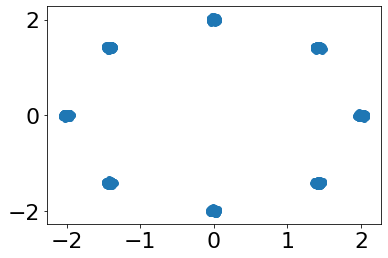

In [6]:
def sample_mog(sample_size, num_of_mixture, std, radius):
    """ Generates data with mixture of gaussian model.

        sample_size -- number of points to sample
        num_of_mixture -- number of gaussion mixture
        std -- scale factor
        radius -- radius of circle that mixture models form

        returns sample points
    """
    D = torch.distributions
    
    # Calculate centers
    thetas = np.linspace(0, 2 * np.pi, num_of_mixture+1)[:-1]
    xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
    centers = torch.stack([torch.Tensor(xs), torch.Tensor(ys)], 1)

    # Assign centers and scales
    means = torch.zeros(num_of_mixture, 1, 2)
    means[:, 0, :] = centers
    scales = torch.ones(num_of_mixture, 1, 2) * std

    # Create prob/weight for each category
    mix = D.Categorical(torch.ones(num_of_mixture,))

    # Distributions
    comp = D.Independent(D.Normal(means, scales), 2)
    gmm = D.MixtureSameFamily(mix, comp)

    return gmm.sample([sample_size,])

def get_sample_from_Gan(G, size=10000, batch_size_for_gen=1024, device=device):
  """ Generates data from generator of a GAN model

      size -- number of points to sample
      batch_size_for_gen -- total batch size for model (num_gen*gen_batch_size)
      device -- device used by pytorch

      returns sample points
  """
  points = []
  for i in range(size//batch_size_for_gen + 1):
    latent = torch.randn(batch_size_for_gen, synthetic_data_configs["z_length"], device=device)

    if (isinstance(G, GeneratorImg)): # for cifar10 dataset latents are between -1, 1
        latent = 2*latent-1 # makes the value between -1,1

    points.append(G(latent).detach().to("cpu").numpy())

  points = np.vstack(points)
  points = points[:size, :]
  return points

# Generate 10000 sample points with 8 mixture models, radius of 2, and scale factor of 0.02   
synthetic_data = sample_mog(10000, 8, 0.02, 2.0).numpy()
synthetic_data = synthetic_data.reshape((-1, 2))

# Draw scatter plot of generated synthetic data
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1])

# Create the dataloader for generating batches
dataloader = torch.utils.data.DataLoader(synthetic_data, 
                                          batch_size=synthetic_data_configs["real_data_batch_size"],
                                          shuffle=True, 
                                          num_workers=1)

# Model Creation


### Model for Synthetic Data

Model details are retrieved from Table 3: Network architecture and hyperparameters for 2D Gaussian data.

In [7]:
class Generator(nn.Module):
  """ Generator model used for synthetic data. """
  def __init__(self, num_gens=8, gen_batch_size=128, z_length=256, **kwargs):
    """ Constructs Generator class.

      num_gens -- number of generators
      gen_batch_size -- number of batch size for each generator
      z_length -- number of latent variables
      **kwargs -- for other keyword arguments like config etc.
    """
    super(Generator, self).__init__()
    self.gen_batch_size = gen_batch_size
    self.num_gens = num_gens
    self.z_length = z_length

    self.gens = []
    # For each generator, define seperate fully-connected layers
    for i in range(num_gens):  
      model = nn.Sequential(
            # input z (latent variables) is fed into linear layer
            nn.Linear(z_length, 128),
            nn.ReLU(),
          )
      self.gens.append(model)
    self.gens = nn.ModuleList(self.gens)

    # For tied parameters, the output of seperate generators will connect to 
    # this shared model
    self.shared_model = nn.Sequential(
          # shared hidden layers
          nn.Linear(128, 128),
          nn.ReLU(),
          nn.Linear(128, 2)
        )

  def forward(self, input):
    # The input batch contains concat of batches for each generator
    if input.shape[0] != self.num_gens * self.gen_batch_size:
      raise Exception("Generator: Input batch size is not equal to num_gens * \
              gen_batch_size. input_batch: {}, num_gens: {}, gen_batch_size: "\
              .format(input.shape[0], self.num_gens, self.gen_batch_size))

    # First layer outputs that are not shared weights
    first_layer = []

    # Batch is splitted for each generator
    for i in range(self.num_gens):
      g_input = input[i*self.gen_batch_size: (i+1) * self.gen_batch_size, :]
      out = self.gens[i](g_input)
      first_layer.append(out)
    
    # Tied parameters, it means concat first layer output and move forward 
    # to shared weights
    shared_out = torch.cat(first_layer, 0)
    out = self.shared_model(shared_out)
    return out

class Discriminator(nn.Module):
  """ Discriminator model used for synthetic data. """
  def __init__(self, num_gens=8, leaky_relu_slope=0.2, **kwargs):
    """ Constructs Generator class.

      num_gens -- number of generators
      leaky_relu_slope -- leaky relu slope
      **kwargs -- for other keyword arguments like config etc.
    """
    super(Discriminator, self).__init__()

    self.num_gens = num_gens

    # The input is fed into a network and the output is connected to two
    # seperate networks.

    # Shared part
    self.model = nn.Sequential(
        nn.Linear(2, 128),
        nn.LeakyReLU(leaky_relu_slope),     
    )

    # Network that predicts which generator produced that sample
    self.multi_class_layer = nn.Sequential(
        nn.Linear(128, self.num_gens),
        nn.Softmax()
    )
    
    # Network that predicts whether sample is real or fake 
    self.binary_class_layer = nn.Sequential(
        nn.Linear(128, 1),
        nn.Sigmoid()
    )

  def forward(self, input):
    out = self.model(input)
    multi_logits = self.multi_class_layer(out)
    binary_logits = self.binary_class_layer(out)
    return multi_logits, binary_logits

### Model for CIFAR-10 Data
Model details are retrieved from Table 4: Network architecture and hyperparameters for the CIFAR-10 dataset.

In [8]:
class GeneratorImg(nn.Module):
  """ Generator model used for CIFAR10 dataset. """
  def __init__(self, num_gens=10, gen_batch_size=12, z_length=100, **kwargs):
    """ Constructs Generator class.

      num_gens -- number of generators
      gen_batch_size -- number of batch size for each generator
      z_length -- number of latent variables
      **kwargs -- for other keyword arguments like config etc.
    """
    super(GeneratorImg, self).__init__()
    self.gen_batch_size = gen_batch_size
    self.num_gens = num_gens
    self.z_length = z_length

    self.gens = []

    # For each generator, define seperate networks
    for i in range(num_gens):  
      model = nn.Sequential(
            # input z (latent variables) is fed into fully-connected layer
            nn.Linear(z_length, 4*4*512),
            nn.BatchNorm1d(4*4*512, momentum=0.1, affine=False),
            nn.ReLU(),
          )
      self.gens.append(model)
    self.gens = nn.ModuleList(self.gens)

    # For tied parameters, the output of seperate generators will connect to 
    # this shared model
    self.shared_model = nn.Sequential(
          # transposed conv1
          # Kernel: 5, Stride 2, Feature maps: 256 
          nn.ConvTranspose2d(512, 256, 5, 2, padding=2, output_padding=1, bias=False),
          nn.BatchNorm2d(256, momentum=0.1, affine=True),
          nn.ReLU(),
          # transposed conv2
          # Kernel: 5, Stride 2, Feature maps: 128 
          nn.ConvTranspose2d(256, 128, 5, 2, padding=2, output_padding=1, bias=False),
          nn.BatchNorm2d(128, momentum=0.1, affine=True),
          nn.ReLU(),
          # transposed conv3
          # Kernel: 5, Stride 2, Feature maps: 3 
          nn.ConvTranspose2d(128, 3, 5, 2, padding=2, output_padding=1, bias=True),
          nn.Tanh(),
        )

  def forward(self, input):
    # The input batch contains concat of batches for each generator
    if input.shape[0] != self.num_gens * self.gen_batch_size:
      raise Exception("Generator: Input batch size is not equal to num_gens * \
              gen_batch_size. input_batch: {}, num_gens: {}, gen_batch_size: "\
              .format(input.shape[0], self.num_gens, self.gen_batch_size))

    # First layer outputs that are not shared weights
    first_layer = []

    # Batch is splitted for each generator
    for i in range(self.num_gens):
      g_input = input[i*self.gen_batch_size: (i+1) * self.gen_batch_size, :]
      out = self.gens[i](g_input)
      first_layer.append(out)
    
    # Reshape each parameter for shared layer
    reshaped_first_layer = [torch.reshape(x, [-1, 512, 4, 4]) for x in first_layer]

    # Tied parameters, it means concat first layer output and move forward 
    # to shared weights
    shared_out = torch.cat(reshaped_first_layer, 0)
    out = self.shared_model(shared_out)
    return out

class DiscriminatorImg(nn.Module):
  """ Discriminator model used for CIFAR10 dataset. """
  def __init__(self, num_gens=10, leaky_relu_slope=0.2, **kwargs):
    """ Constructs Generator class.

      num_gens -- number of generators
      leaky_relu_slope -- leaky relu slope
      **kwargs -- for other keyword arguments like config etc.
    """
    super(DiscriminatorImg, self).__init__()

    self.num_gens = num_gens
    
    # The input is fed into a network and the output is connected to two
    # seperate networks.
    self.model = nn.Sequential(
        # conv 1
        # Kernel: 5, Stride 2, Feature maps: 128
        nn.Conv2d(3, 128, 5, 2, 1),
        nn.BatchNorm2d(128, momentum=0.1, affine=True),
        nn.LeakyReLU(leaky_relu_slope),
        # conv 2
        # Kernel: 5, Stride 2, Feature maps: 256
        nn.Conv2d(128, 256, 5, 2, 1),
        nn.BatchNorm2d(256, momentum=0.1, affine=True),
        nn.LeakyReLU(leaky_relu_slope),
        # conv 3
        # Kernel: 5, Stride 2, Feature maps: 512
        nn.Conv2d(256, 512, 5, 2, 1),
        nn.BatchNorm2d(512, momentum=0.1, affine=True),
        nn.LeakyReLU(leaky_relu_slope),
    )

    # Network that predicts which generator produced that sample
    self.multi_class_layer = nn.Sequential(
        nn.Linear(512*3*3, self.num_gens),
        nn.Softmax()
    )
    
    # Network that predicts whether sample is real or fake 
    self.binary_class_layer = nn.Sequential(
        nn.Linear(512*3*3, 1),
        nn.Sigmoid()
    )

  def forward(self, input):
    batch_size = input.shape[0]
    out = self.model(input)
    out = torch.reshape(out, [batch_size, -1])

    multi_logits = self.multi_class_layer(out)
    binary_logits = self.binary_class_layer(out)
    return multi_logits, binary_logits

# Load pretrained model

In [9]:
def load_model(path, config=None, device="cpu"):
  """ Loads pytorch checkpoint from given path.
  """
  try:
    checkpoint = torch.load(path)
    print("Model successfully loaded from given path. ", path)
    config = checkpoint["config"]
  except Exception as e:
    if config is None: # if there is no config provided
      print("The model is not found at given path, and config is not provided!")
      return None
  
    print("Creating a new model!")
    checkpoint = {}

  default_cp = {"kl_distances": [], 
                  "batch_offset": 0,
                  "epoch": 0, 
                  "config": config}

  for key in default_cp:
    if key not in checkpoint:
      checkpoint[key] = default_cp[key]
      
  if config.get("datatype") == "cifar10":
    G = GeneratorImg(**config).to(device)
    D = DiscriminatorImg(**config).to(device)
  else:
    G = Generator(**config).to(device)
    D = Discriminator(**config).to(device)

  # Initialize weights
  G.apply(lambda x: initialize_weights(x, config))
  D.apply(lambda x: initialize_weights(x, config))

  # Setup Adam optimizers for both G and D
  opt1 = optim.Adam(G.parameters(), lr=config["learning_rate"],
                    betas=(config["adam_optimizer_beta1"],
                           config["adam_optimizer_beta2"]))
   
  opt2 = optim.Adam(D.parameters(), lr=config["learning_rate"],
                    betas=(config["adam_optimizer_beta1"],
                           config["adam_optimizer_beta2"]))
  # If a model is loaded, the state is reloaded. 
  if checkpoint.get("G"):
    G.load_state_dict(checkpoint["G"])
  if checkpoint.get("D"):
    D.load_state_dict(checkpoint["D"])
  if checkpoint.get("opt1"):
    opt1.load_state_dict(checkpoint["opt1"])
  if checkpoint.get("opt2"):
    opt2.load_state_dict(checkpoint["opt2"])
  
  return G, D, opt1, opt2, checkpoint

# Train

In [10]:
def train(config, dataloader, G=None, D=None, optimizerD=None, optimizerG=None,
          synthetic_data=[], verbose=False, epoch_offset=0, 
          kl_distance_sample_interval=10, datatype="synthetic", device="cpu",
          batch_offset = 0, kl_distances=None):
  """ A generic train function for both models.

    config -- model configurations
    dataloader -- dataloader for generating and fetching batches
    G -- Generator model
    D -- Discriminator model
    optimizerG -- Generator optimizer
    optimizerD -- Discriminator optmizer
    synthetic_data -- Synthetic data samples for gaussian experiments
    verbose -- Enable verbose output
    epoch_offset -- Offset of epoch for the pretrained models to continue the training
    batch_offset -- Offset of batch for the pretrained models to continue the training
    kl_distance_sample_interval -- Interval for computing kl-divergence
    datatype -- "synthetic" or "cifar10"
    device -- pytorch device 
    kl-distances -- State for storing the previous kl-divergence values
  """
  if datatype not in ["synthetic", "cifar10"]:
    raise Exception("Datatype should be one of synthetic or cifar10!")

  config["datatype"] = config.get("datatype", "synthetic_data")

  # Real samples are labeled with 1, and fakes are with 0
  real_label = 1
  fake_label = 0

  # Arrange the model name to save
  model_name_format = "{datatype}_numgen{num_gens:02d}_beta{rbeta:02d}"
  model_name = model_name_format.format(**config,
                                        rbeta=int(config["regularization_beta"]*100))

  model_save_interval = config.get("model_save_interval")
  # Binary cross-entropy loss for real-fake discrimination
  binary_loss = nn.BCELoss()
  # Negative log-likelihood loss for generator discrimination
  multi_loss = nn.NLLLoss()

  kl_distances = [] if kl_distances is None else kl_distances

  if G is None:
    if datatype == "cifar10":
      G = GeneratorImg(**config)
    else:
      G = Generator(**config)

  if D is None:
    if datatype == "cifar10":
      D = DiscriminatorImg(**config)
    else:
      D = Discriminator(**config)
  
  # Load the models to device
  G = G.to(device)
  D = D.to(device)

  # Setup Adam optimizers for both G and D
  if optimizerG is None:
    optimizerG = optim.Adam(G.parameters(),
                            lr=config["learning_rate"],
                            betas=(config["adam_optimizer_beta1"],
                                    config["adam_optimizer_beta2"]))
    
  if optimizerD is None:
    optimizerD = optim.Adam(D.parameters(),
                            lr=config["learning_rate"],
                            betas=(config["adam_optimizer_beta1"],
                                    config["adam_optimizer_beta2"]))

  torch.autograd.set_detect_anomaly(True)
  total_batch_count = 0
  num_epochs = config["num_of_iterations"]

  start_time = timeit.default_timer()
  for epoch in range(epoch_offset, num_epochs):
    # For each batch in the dataloader
    for batch_idx, data in enumerate(dataloader):
      if batch_idx + batch_offset > len(dataloader):
        break
      # Update weights of Discriminator
      D.zero_grad()
      ## Train with all-real batch
      # Format batch
      real_data = data.to(device)
      b_size = real_data.size(0)
      bin_label = torch.full((b_size,), real_label, device=device)

      # Forward pass real batch through D
      multi_output, binary_output = D(real_data)
      multi_output = multi_output.view(-1)
      binary_output = binary_output.view(-1)

      # Calculate loss on all-real batch
      errD_bin_real = binary_loss(binary_output, bin_label)

      # Discriminator's success on real data
      D_x = binary_output.mean().item()

      ## Train with all-fake batch
      # Generate batch of latent vectors
      batch_size_for_gen = config["gen_batch_size"]*config["num_gens"]
      latent = torch.randn(batch_size_for_gen, config["z_length"], device=device)
      
      if datatype == "cifar10":
        latent = 2*latent-1 # makes the value between -1,1

      # Generate fake image batch with G
      fake = G(latent)
      bin_label = torch.full((batch_size_for_gen,), fake_label, device=device)
      multi_label = torch.tensor( [i // config["gen_batch_size"] for i in range(batch_size_for_gen)],
                                 device=device)

      # Classify all fake batch with D
      multi_output, binary_output = D(fake.detach())
      binary_output = binary_output.view(-1)

      # Calculate D's loss on the all-fake batch
      errD_bin_fake = binary_loss(binary_output, bin_label)
      errD_multi_fake = multi_loss(multi_output, multi_label)

      # Add the gradients from the all-real and all-fake batches
      errD = errD_bin_real + errD_bin_fake + errD_multi_fake
      errD.backward()

      # Update D
      optimizerD.step()

      # Discriminator's success on fake data
      D_G_z1 = binary_output.mean().item()
      
      # Update weights of Generator    
      G.zero_grad()

      # Generate fake image batch with G
      fake = G(latent)
      bin_label = torch.full((batch_size_for_gen,), fake_label, device=device)
      multi_label = torch.tensor( [i // config["gen_batch_size"] \
                                   for i in range(batch_size_for_gen)],
                                 device=device)

      # Classify all fake batch with D
      multi_output, binary_output = D(fake)
      binary_output = binary_output.view(-1)

      # Calculate D's loss on the all-fake batch
      errD_multi_fake = multi_loss(multi_output, multi_label)


      bin_label = torch.full((batch_size_for_gen,), real_label, device=device)  # fake labels are real for generator cost

      # Since we just updated D, perform another forward pass of all-fake batch through D
      multi_output, binary_output = D(fake)
      binary_output = binary_output.view(-1)

      # Calculate G's loss based on this output
      errG_bin_fake = binary_loss(binary_output, bin_label)
      errG_multi_fake = config["regularization_beta"] * errD_multi_fake
      errG = errG_bin_fake + errG_multi_fake

      # Calculate gradients for G
      errG.backward()

      # Update G
      optimizerG.step()
      
      # Discriminator's success on fake data after updating the generator's weights
      D_G_z2 = binary_output.mean().item()

      total_batch_count += 1
      # Output training stats
      if verbose  \
          and config.get("print_status_interval", 0) > 0 \
          and total_batch_count % config["print_status_interval"] == 0:
          elapsed = timeit.default_timer() - start_time
          start_time = timeit.default_timer()
          fmt = '%s\t[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\t elapsed: %.2f'
          print(fmt% (model_name, epoch + 1, num_epochs, batch_idx+batch_offset+1, len(dataloader), 
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, elapsed))
      
      if config.get("batch_save_interval")  and \
        config.get("batch_save_interval") > 0 and \
        (batch_idx + batch_offset + 1) % config.get("batch_save_interval") == 0:
        path = "{}/{}_iterno{:05d}_batch{:05d}".format(config["model_save_dir"],
                  model_name, 
                  epoch + 1, 
                  batch_idx + batch_offset + 1)
        save_model(path, G, D, optimizerG, optimizerD, 
                 epoch=epoch + 1,
                 batch_offset = batch_idx + batch_offset + 1,
                 config=config, verbose=verbose)

          
    if kl_distance_sample_interval and (epoch + 1) % kl_distance_sample_interval == 0:
      generated_samples = get_sample_from_Gan(G, batch_size_for_gen=batch_size_for_gen, device=device)
      kl_distance = symmetric_KL_distance(synthetic_data, generated_samples)
      kl_distances.append((epoch + 1, kl_distance))
      if verbose:
        print("KL distance is calculated Epoch: {}".format(epoch + 1))

    batch_offset = 0
    # Save model if requested
    if model_save_interval and model_save_interval > 0 \
      and (epoch+1) % model_save_interval == 0:
      path = "{}/{}_iterno{:05d}".format(config["model_save_dir"],
                                              model_name, epoch + 1)
      save_model(path, G, D, optimizerG, optimizerD, 
                 epoch=epoch + 1, 
                 config=config, kl_distances=kl_distances,
                 verbose=verbose)

  return G, D, kl_distances

# Experiments

## Figure 2: The comparison of our MGAN and GAN’s variants on 2D synthetic dataset. (Only MGAN results)
(a) Symmetric KL divergence.
(c) Evolution of data (in blue) generated by  ̶G̶A̶N̶,̶ ̶U̶n̶r̶o̶l̶l̶e̶d̶G̶A̶N̶,̶ ̶D̶2̶G̶A̶N̶ and **our MGAN** from the top row to the bottom, respectively. Data sampled from the true mixture of 8 Gaussians are red.

In [ ]:
# This cell is for training
# If you will use a pre-trained model for only sampling, skip this cell
# Training a model for synthetic data

config = copy.deepcopy(synthetic_data_configs)
# Override default parameters for the experiment
config["num_gens"] = 8
config["model_save_interval"] = 100
config["num_of_iterations"] = 1000
config["print_status_interval"] = 100

path = find_last_model_path(config)
G, D, opt1, opt2, checkpoint = load_model(path, config=config, device=device)

epoch = checkpoint["epoch"]
kl_distances = checkpoint["kl_distances"]
G, D, _ = train(config, dataloader, G=G, D=D, optimizerG=opt1, optimizerD=opt2,
              epoch_offset=epoch, kl_distance_sample_interval=10,
              synthetic_data=synthetic_data, verbose=True, 
              device=device, kl_distances=kl_distances)

In [11]:
# Load pre-trained models from google drive
model_list = [
("https://drive.google.com/open?id=1j98WA8A3QVfzNjgQ2v-ApNzsyrOXXI_h", "synthetic_numgen08_beta50_iterno00100"),
("https://drive.google.com/open?id=1-4CY-cuGOUsuwFUVlhq0Zx5TUDZoTRNO", "synthetic_numgen08_beta50_iterno00200"),
("https://drive.google.com/open?id=1-EDPVwyZKmjD2cswVfY_e3hMPiXd07b0", "synthetic_numgen08_beta50_iterno00500"),
("https://drive.google.com/open?id=1-K2gSrYTl0N57qyVd2SeEd7pzOKXc9lJ", "synthetic_numgen08_beta50_iterno01000"),
]

trained_models = []

# Load each model into trained_models list
for idx, (file_id, model_name) in enumerate(model_list):
  path = "pretrained_models/" + model_name
  download_pretrained_model(file_id, path, unzip=False, overwrite=True)

  G, D, opt1, opt2, checkpoint = load_model(path, config=None, device=device)
  config = checkpoint["config"]
  trained_models.append((G, config, checkpoint))

file_id fetched from url:  1j98WA8A3QVfzNjgQ2v-ApNzsyrOXXI_h
Model successfully loaded from given path.  pretrained_models/synthetic_numgen08_beta50_iterno00100
file_id fetched from url:  1-4CY-cuGOUsuwFUVlhq0Zx5TUDZoTRNO
Model successfully loaded from given path.  pretrained_models/synthetic_numgen08_beta50_iterno00200
file_id fetched from url:  1-EDPVwyZKmjD2cswVfY_e3hMPiXd07b0
Model successfully loaded from given path.  pretrained_models/synthetic_numgen08_beta50_iterno00500
file_id fetched from url:  1-K2gSrYTl0N57qyVd2SeEd7pzOKXc9lJ
Model successfully loaded from given path.  pretrained_models/synthetic_numgen08_beta50_iterno01000


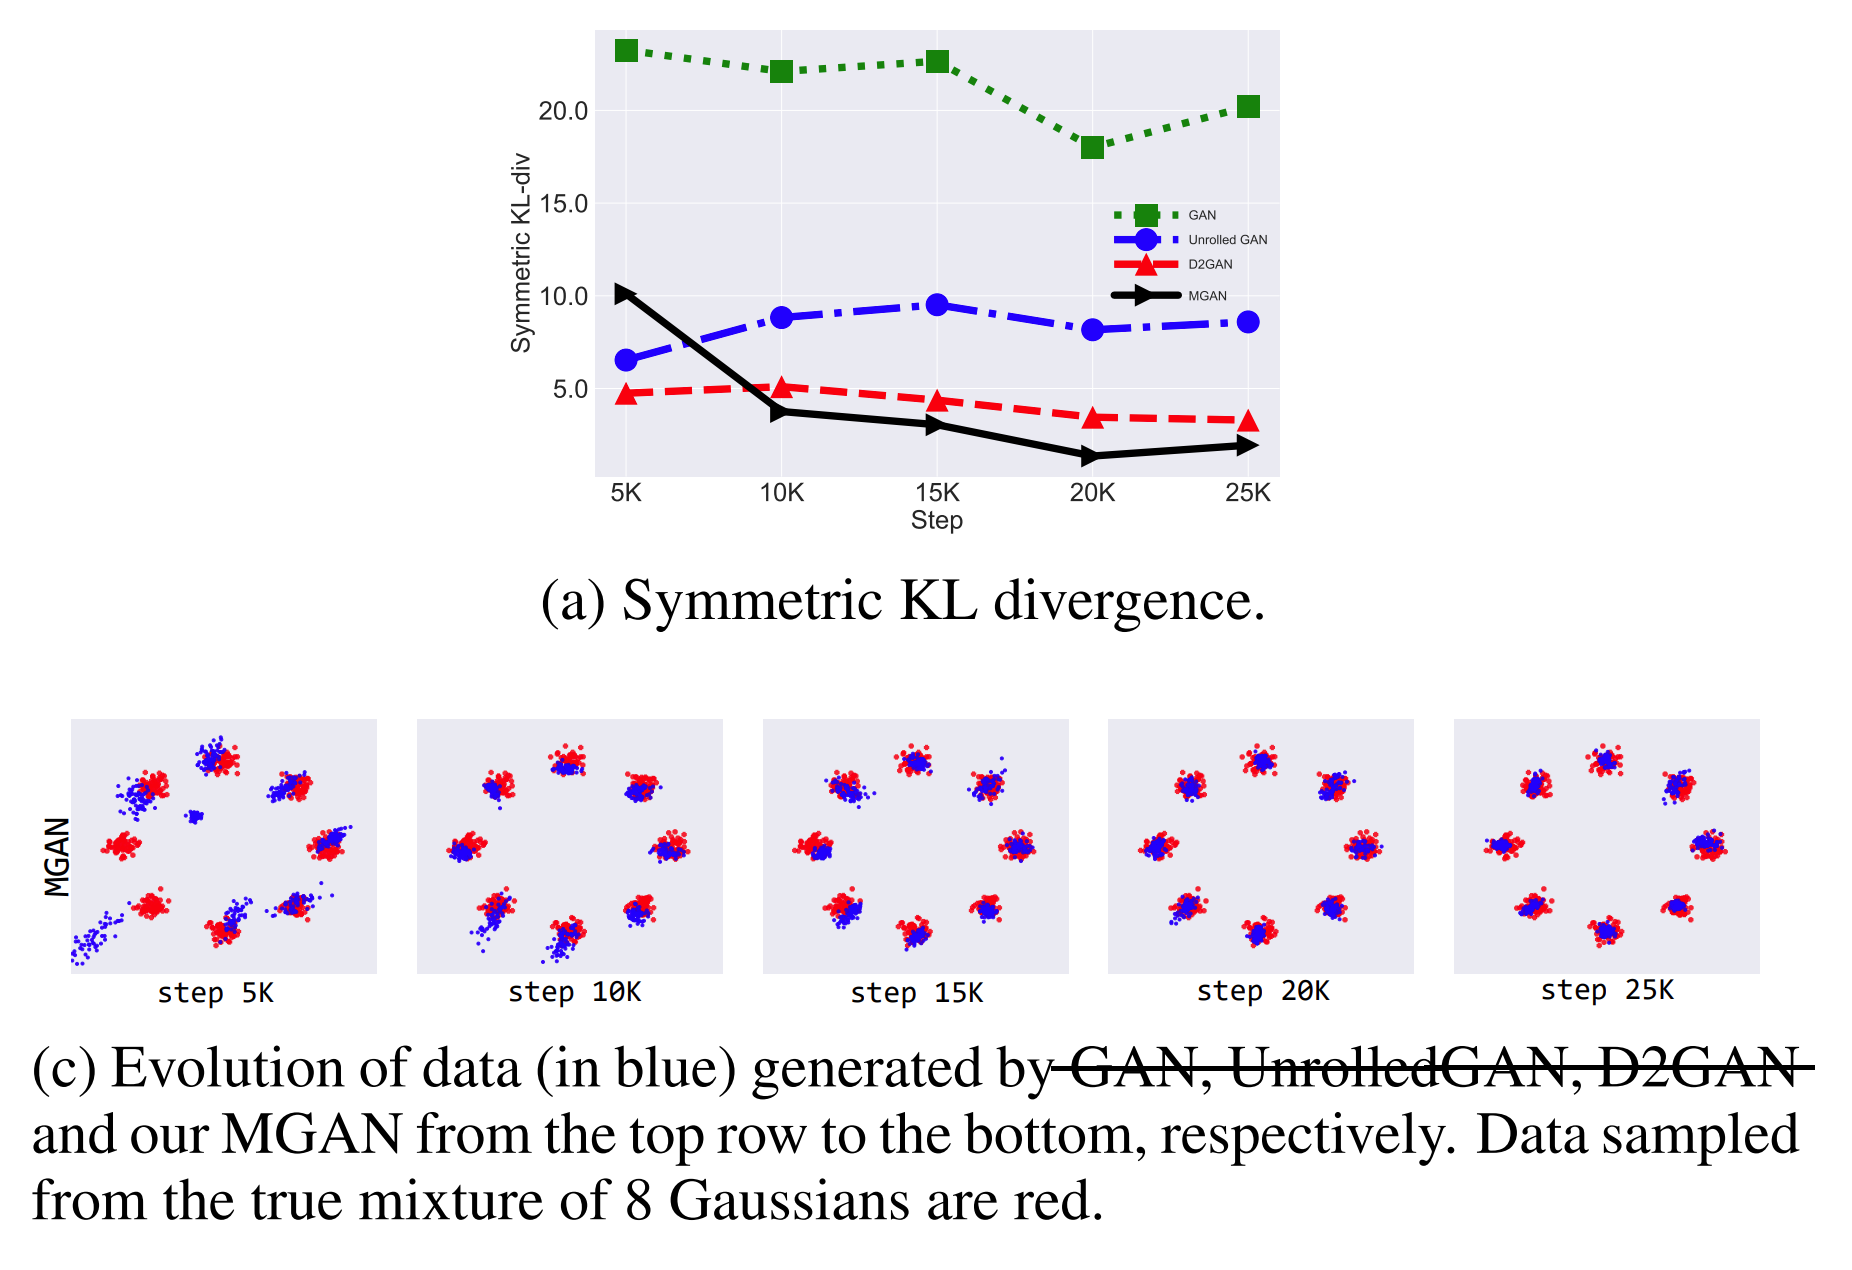

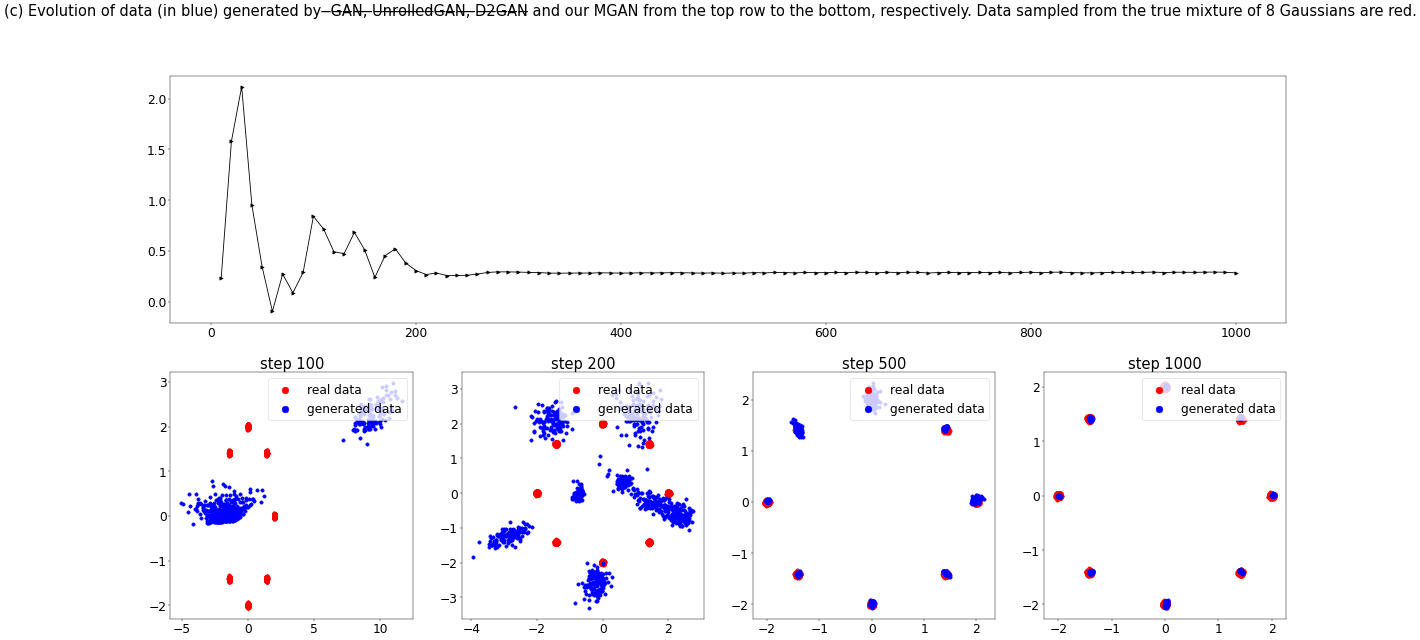

In [12]:
# Draw line and scatter plots for trained_models
fig = plt.figure(figsize=(36, 18), dpi=40, constrained_layout=False)
spec = gridspec.GridSpec(nrows=2, ncols=len(model_list), figure=fig)

for idx, (G, config, checkpoint) in enumerate(trained_models):
  fg_ax = fig.add_subplot(spec[1, idx])
  draw_scatter_plot(G, config, synthetic_data, device, fg_ax, plot_together=True)
  fg_ax.set_title("step {}".format(checkpoint["epoch"]))

# fig, ax = plt.subplots(2, len(configs), sharex='col', sharey='row', figsize=(35,len(configs)))
fig.suptitle("(c) Evolution of data (in blue) generated by  ̶G̶A̶N̶,̶ ̶U̶n̶r̶o̶l̶l̶e̶d̶G̶A̶N̶,̶ ̶D̶2̶G̶A̶N̶ and our MGAN from the top row to the bottom, respectively. Data sampled from the true mixture of 8 Gaussians are red.")

# retrive last model
checkpoint = trained_models[-1][2]

# get KL distances
kl_distances = checkpoint["kl_distances"]
fg_ax = fig.add_subplot(spec[0, :])

# unzip epoch vs kl-distance
x,y = list(zip(*kl_distances))
fg_ax.plot(x, y, "black", marker=">")

## Figure 6: Samples generated by MGAN models trained on synthetic data with 2, 3, 4 and 10 generators. Data samples from the 8 Gaussians are in red, and generated data by each generator are in a different color.

**The effect of the number of generators on generated samples.** Fig. 6 shows samples produced by MGANs with different numbers of generators trained on synthetic data for 25,000 epochs. The model with 1 generator behaves similarly to the standard GAN as expected. The models with 2, 3 and 4 generators all successfully cover 8 modes, but the ones with more generators draw fewer points scattered between adjacent modes. Finally, the model with 10 generators also  covers 8 modes wherein 2 generators share one mode and one generator hovering  around another mode.

In [ ]:
# This cell is for training
# If you will use a pre-trained model for only sampling, skip this cell
# Train models for different number of generators
generator_hyperparameters = [1, 2, 3, 4, 10]
generators, configs = [], []
for gen_opt in generator_hyperparameters:
  print("Training with {} generator".format(gen_opt))
  config = copy.deepcopy(synthetic_data_configs)
  
  # Override default parameters for the experiment
  config["num_gens"] = gen_opt
  config["num_of_iterations"] = 25000
  config["model_save_interval"] = 1000

  # Check is there any saved model
  path = find_last_model_path(config)
  G, D, opt1, opt2, checkpoint = load_model(path, config=config, device=device)
  epoch = checkpoint["epoch"]
  G, D, _ = train(config, dataloader, G=G, D=D, optimizerG=opt1, optimizerD=opt2,
                epoch_offset=epoch, kl_distance_sample_interval=0,
                verbose=True, device=device)
  generators.append(G)
  configs.append(config)

In [13]:
# If you trained the model from sctrach in the previous cell, skip this cell
# Load pre-trained models from google drive
model_list = [("1061ytoXC0CMuY_CmTXE_ebCcQJqxEOkR", "numgen01_beta50"),
              ("1-_PYM38V9J0kPrhzxThOw2XnPw2eRwur", "numgen02_beta50"),
              ("10ooPtfxD-W_qzzE3aPLk2g9tV9vQQijA", "numgen03_beta50"),
              ("1-4SK-n0QEjepsX2WKlKm92YbV7ei9zxL", "numgen04_beta50"),
              ("1-4qFi-MViR1Oq7QcHwyVXzDZP5Vcq4lS", "numgen10_beta50"),]

generators, configs = [], []

# Load each model into generators and configs lists
for file_id, model_name in model_list:
  path = "pretrained_models/gen_experiment/" + model_name
  download_pretrained_model(file_id, path, unzip=False)

  G, D, opt1, opt2, checkpoint = load_model(path, config=None, device=device)
  generators.append(G)
  configs.append(checkpoint["config"])

Model successfully loaded from given path.  pretrained_models/gen_experiment/numgen01_beta50
Model successfully loaded from given path.  pretrained_models/gen_experiment/numgen02_beta50
Model successfully loaded from given path.  pretrained_models/gen_experiment/numgen03_beta50
Model successfully loaded from given path.  pretrained_models/gen_experiment/numgen04_beta50
Model successfully loaded from given path.  pretrained_models/gen_experiment/numgen10_beta50


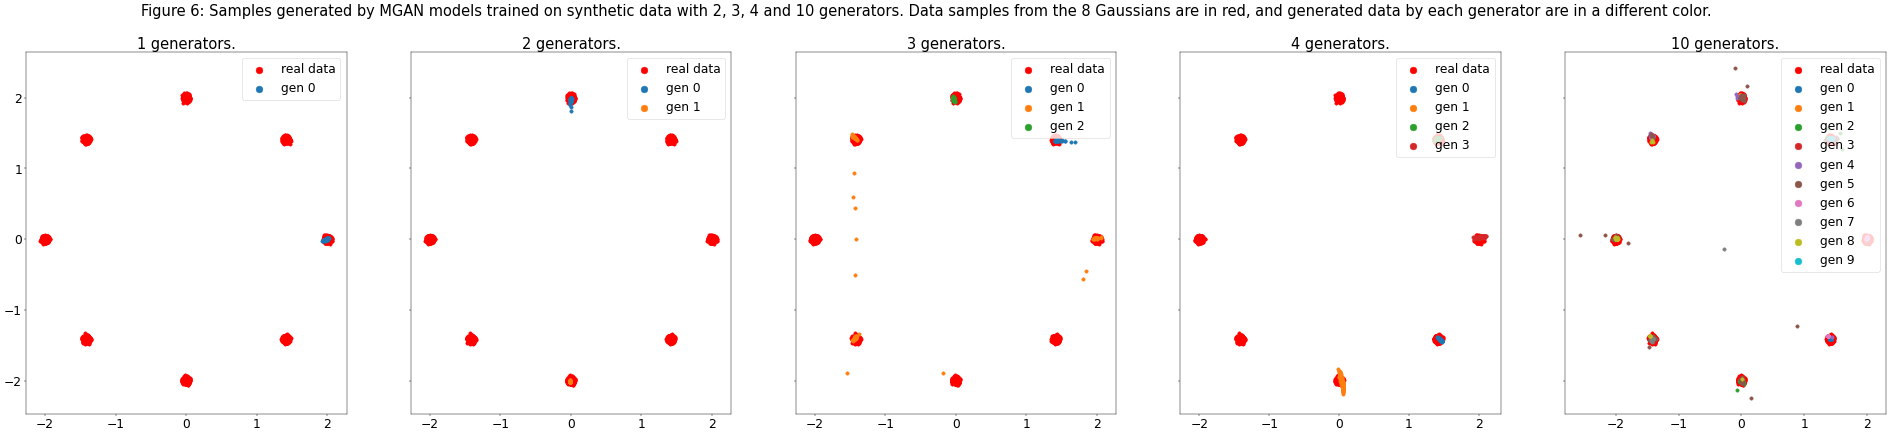

In [14]:
# Draw scatter plots for each generator in generators list
fig, ax = plt.subplots(1, len(generators), sharex='col', sharey='row', figsize=(len(configs)*12, 12), dpi=40)
fig.suptitle("Figure 6: Samples generated by MGAN models trained on synthetic data with 2, 3, 4 and 10 generators. Data samples from the 8 Gaussians are in red, and generated data by each generator are in a different color.")
for i in range(len(generators)):
    draw_scatter_plot(generators[i], configs[i], synthetic_data, device, ax[i])
    ax[i].set_title("{} generators.".format(configs[i]["num_gens"]))

## Figure 7: Samples generated by MGAN models trained on synthetic data with different values of diversity coefficient β. Generated data are in blue and data samples from the 8 Gaussians are in red.

**The effect of β on generated samples.** To examine the behavior of the diversity coefficient β, Fig. 7 compares samples produced by our MGAN with 4 generators after 1,000 epochs of training with different values of β. Without the JSD force (β = 0), generated samples cluster around one mode. When β = 0.25, generated data clusters near 4 different modes. When β = 0.75 or 1.0, the JSD force is too strong and causes the generators to collapse, generating 4 increasingly tight clusters. When β = 0.5, generators successfully cover all of the 8 modes.

In [ ]:
# This cell is for training
# If you will use a pre-trained model for only sampling, skip this cell
# Train models for different beta values
beta_hyperparameters = [0., 0.25, 0.5, 0.75, 1.0]
generators, configs = [], []
for beta in beta_hyperparameters:
  print("Training with {} beta".format(beta))
  config = copy.deepcopy(synthetic_data_configs)

  # Override default parameters for the experiment
  config["num_gens"] = 4
  config["num_of_iterations"] = 20
  config["regularization_beta"] = beta
  config["model_save_interval"] = 10

  # Check is there any saved model
  path = find_last_model_path(config)
  G, D, opt1, opt2, checkpoint = load_model(path, config=config, device=device)
  epoch = checkpoint["epoch"]
  G, D, _ = train(config, dataloader, G=G, D=D, optimizerG=opt1, optimizerD=opt2,
                epoch_offset=epoch, kl_distance_sample_interval=0,
                verbose=True, device=device)
  generators.append(G)
  configs.append(config)

In [15]:
# If you trained the model from sctrach in the previous cell, skip this cell
# Load pre-trained models from google drive
model_list = [("https://drive.google.com/open?id=1-8hWNsUNguoi9DZRzGEJHNZgdT4mFR21", "numgen04_beta00"),
              ("https://drive.google.com/open?id=1-OHJlUc6pt81xaPLtTjuyckHulndbsTr", "numgen04_beta25"),
              ("https://drive.google.com/open?id=1-4SK-n0QEjepsX2WKlKm92YbV7ei9zxL", "numgen04_beta50"),
              ("https://drive.google.com/open?id=1-b3B9QS2MZjS1F6RA8_HMhBzMj6xNjsA", "numgen04_beta75"),
              ("https://drive.google.com/open?id=1-gmYzyKYk1s1f4fqJRwmHDjeEpynna1z", "numgen04_beta100"),]

generators, configs = [], []

# Load each model into generators and configs lists
for file_id, model_name in model_list:
  path = "pretrained_models/beta_experiment/" + model_name
  download_pretrained_model(file_id, path, unzip=False, overwrite=False)

  G, D, opt1, opt2, checkpoint = load_model(path, config=None, device=device)
  generators.append(G)
  configs.append(checkpoint["config"])

file_id fetched from url:  1-8hWNsUNguoi9DZRzGEJHNZgdT4mFR21
Model successfully loaded from given path.  pretrained_models/beta_experiment/numgen04_beta00
file_id fetched from url:  1-OHJlUc6pt81xaPLtTjuyckHulndbsTr
Model successfully loaded from given path.  pretrained_models/beta_experiment/numgen04_beta25
file_id fetched from url:  1-4SK-n0QEjepsX2WKlKm92YbV7ei9zxL
Model successfully loaded from given path.  pretrained_models/beta_experiment/numgen04_beta50
file_id fetched from url:  1-b3B9QS2MZjS1F6RA8_HMhBzMj6xNjsA
Model successfully loaded from given path.  pretrained_models/beta_experiment/numgen04_beta75
file_id fetched from url:  1-gmYzyKYk1s1f4fqJRwmHDjeEpynna1z
Model successfully loaded from given path.  pretrained_models/beta_experiment/numgen04_beta100


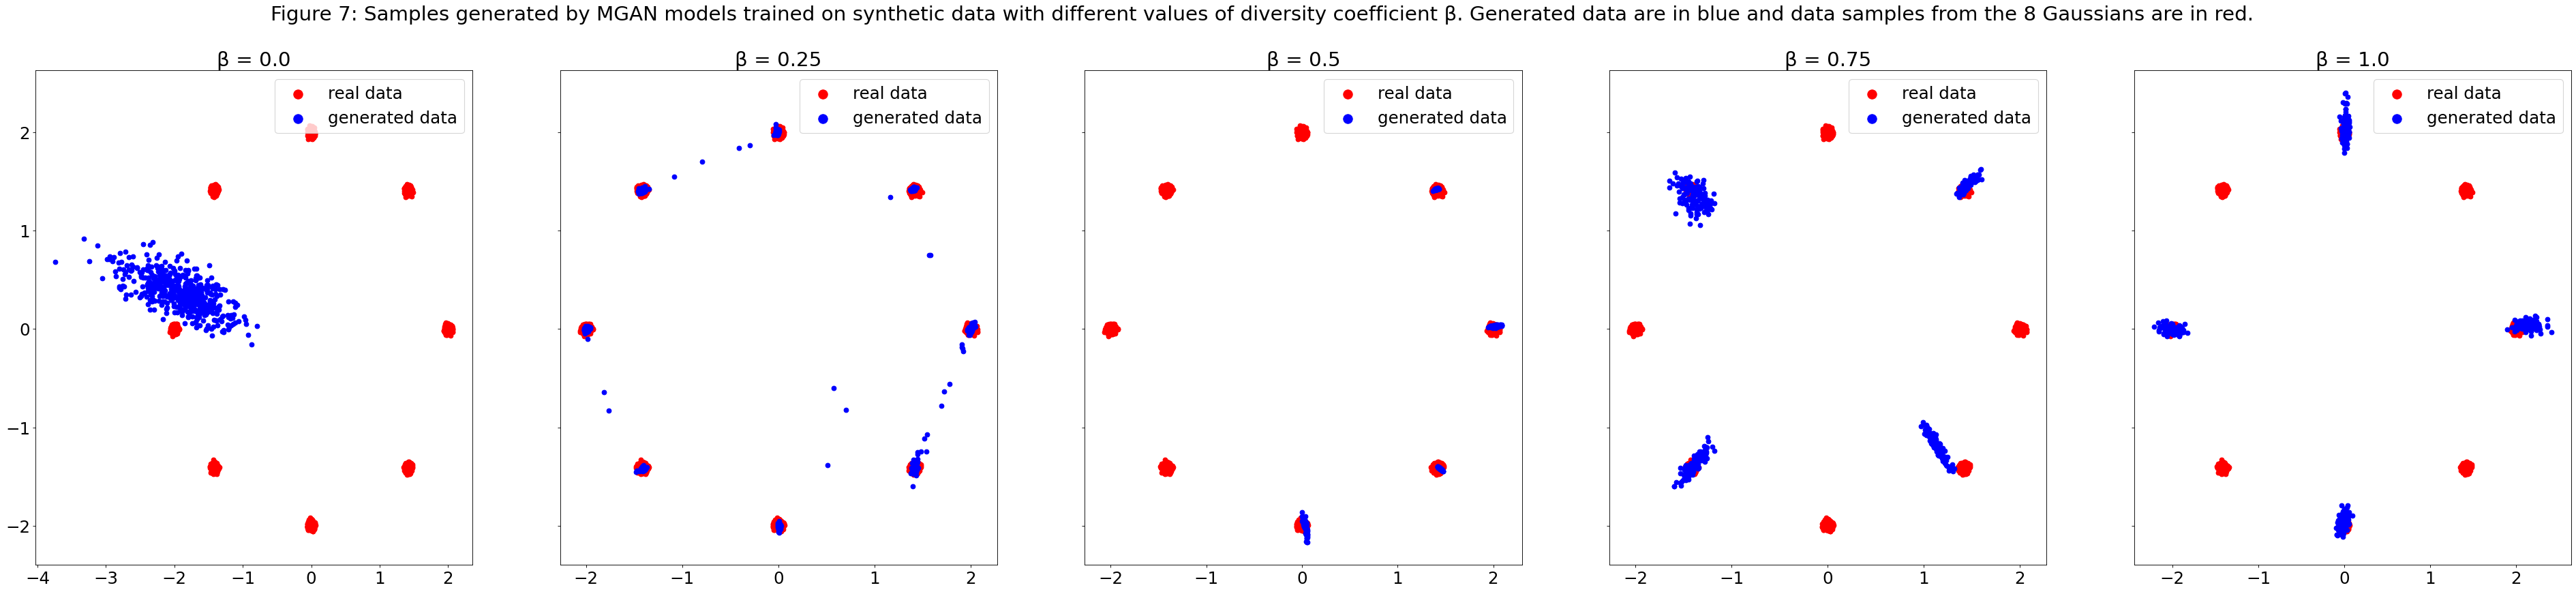

In [18]:
# Draw scatter plots for each generator with different beta values in generators list
fig, ax = plt.subplots(1, len(generators), sharex='col', sharey='row', figsize=(len(configs)*12,12), dpi=80)
fig.suptitle("Figure 7: Samples generated by MGAN models trained on synthetic data with different values of diversity coefficient β. Generated data are in blue and data samples from the 8 Gaussians are in red.")
for i in range(len(generators)):
    draw_scatter_plot(generators[i], configs[i], synthetic_data, device, ax[i], plot_together=True)
    ax[i].set_title("β = {}".format(configs[i]["regularization_beta"]))

# CIFAR10 Train

## Load CIFAR10 dataset

In [19]:
# Downloads CIFAR10 and prepares dataloader for batch generation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset = [x[0] for x in trainset]
cifar10_dataloader = torch.utils.data.DataLoader(trainset, 
                                         batch_size=cifar10_data_configs["real_data_batch_size"],
                                          shuffle=True, num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data


## Train MGAN on CIFAR-10 dataset

In [ ]:
# This cell is for training
# If you will use a pre-trained model for only sampling, skip this cell
# Train models with cifar10 dataset
config = copy.deepcopy(cifar10_data_configs)
config["num_of_iterations"] = 250
path = find_last_model_path(config)
config["model_save_interval"] = 50
config["batch_save_interval"] = 0

G, D, opt1, opt2, checkpoint = load_model(path, config=config, device=device)
epoch = checkpoint["epoch"]
batch_offset = checkpoint["batch_offset"]

G, D, _ = train(config, cifar10_dataloader, G=G, D=D, optimizerG=opt1, optimizerD=opt2,
              epoch_offset=epoch, kl_distance_sample_interval=0, verbose=True,
              datatype="cifar10", batch_offset=batch_offset, device=device)

## Figure 9: Images generated by MGAN trained on the CIFAR-10 dataset

In [20]:
# If you trained the model from sctrach in the previous cell, skip this cell
# Load pre-trained model from google drive

# Model is trained for 250 epochs with 10 generators and 0.01 beta value
file_id, model_name = ("1-jsnFZyy0gfEjg51nZGpi938KJ3QnhlH", "cifar10_numgen10_beta01_iterno00250")
path = "pretrained_models/cifar10_experiment/" + model_name
download_pretrained_model(file_id, path, unzip=False, overwrite=False)

G, D, opt1, opt2, checkpoint = load_model(path, config=None, device=device)

Model successfully loaded from given path.  pretrained_models/cifar10_experiment/cifar10_numgen10_beta01_iterno00250


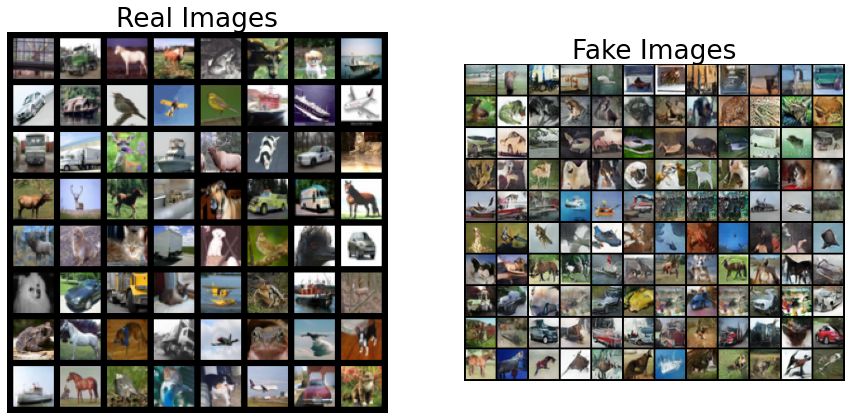

In [21]:
# Grab a batch of real images from the dataloader

config = checkpoint["config"]
batch_size_for_gen = config["num_gens"] * config["gen_batch_size"]

latent = torch.randn(batch_size_for_gen, config["z_length"], device=device)
latent = 2*latent-1 # makes the value between -1,1

fake_batch = G(latent).detach()
fake_batch = fake_batch.to("cpu")

fake_grid = vutils.make_grid(fake_batch, nrow=12, padding=2, normalize=True)

real_batch = next(iter(cifar10_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to("cpu"), padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_grid, (1,2,0)))
plt.show()

## Figure 5: Images generated by our MGAN trained on CIFAR10 at different epochs. Samples in each row from the top to the bottom correspond to a different generator

For the following epoch numbers, the figures are sampled with same latent to observe the progress.

Model is already downloaded. path:  pretrained_models/cifar10_experiment/cifar10_numgen10_beta01_iterno00020
Model successfully loaded from given path.  pretrained_models/cifar10_experiment/cifar10_numgen10_beta01_iterno00020
Model is already downloaded. path:  pretrained_models/cifar10_experiment/cifar10_numgen10_beta01_iterno00050
Model successfully loaded from given path.  pretrained_models/cifar10_experiment/cifar10_numgen10_beta01_iterno00050
Model is already downloaded. path:  pretrained_models/cifar10_experiment/cifar10_numgen10_beta01_iterno00250
Model successfully loaded from given path.  pretrained_models/cifar10_experiment/cifar10_numgen10_beta01_iterno00250


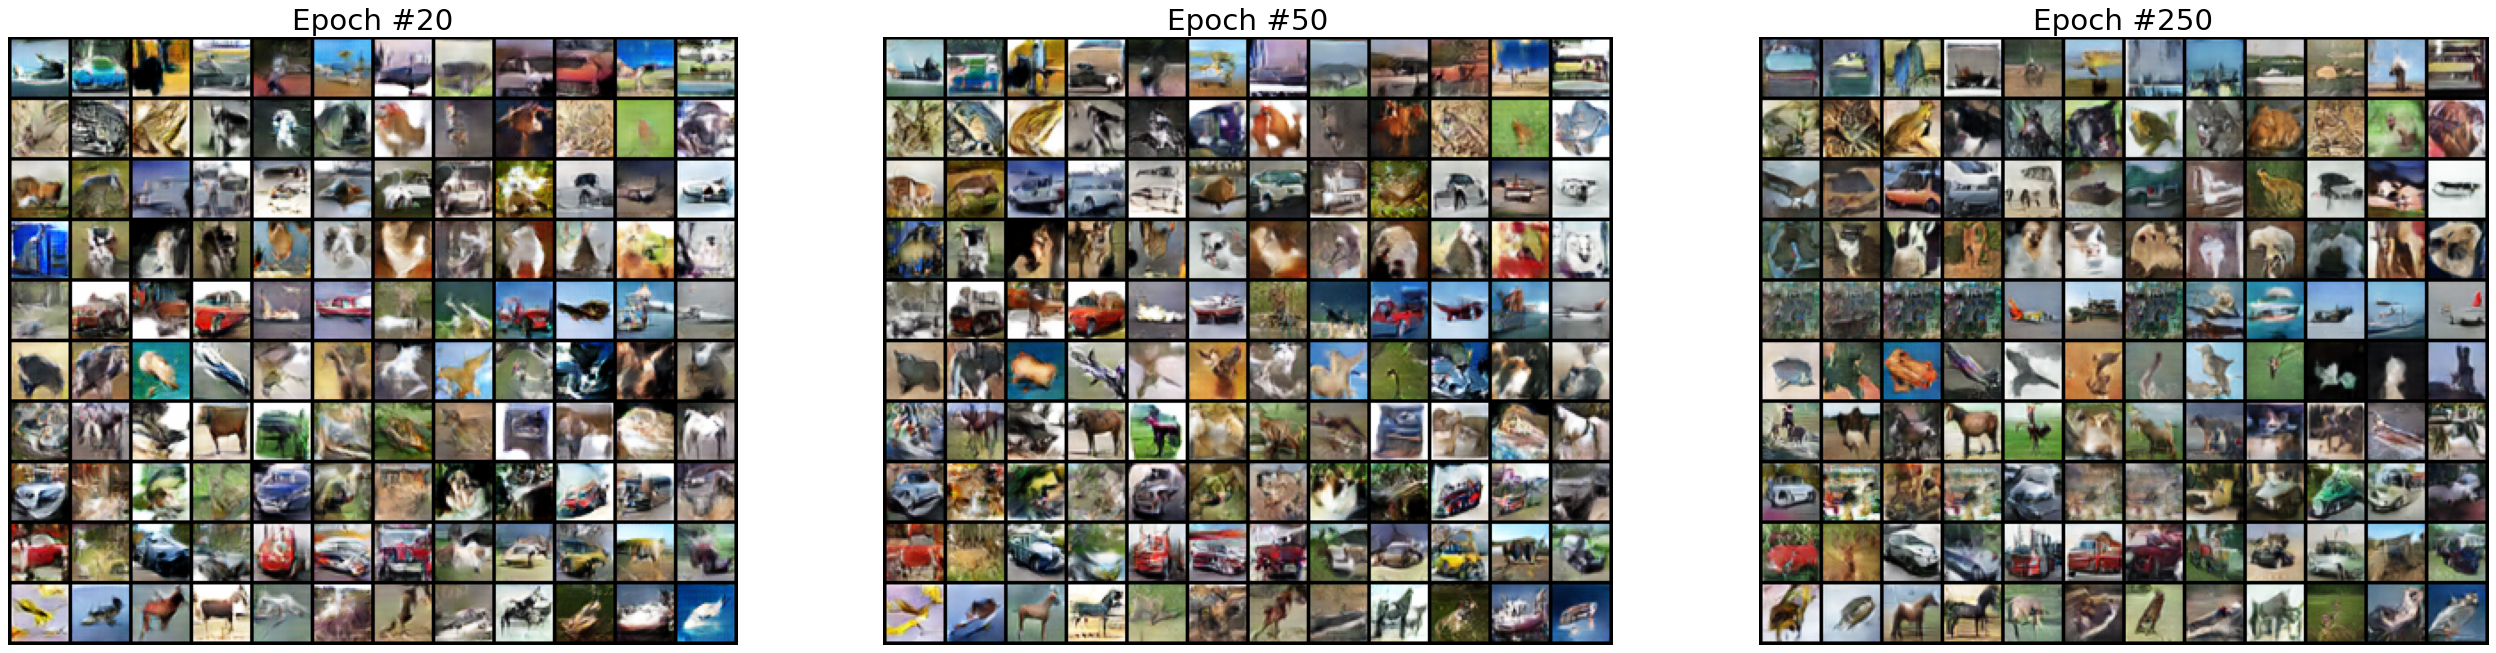

In [23]:
# Load pre-trained models from google drive
# Models are trained for 20, 50, and 250 epochs with 10 generators and 0.01 beta values
model_list = [("1-9543MSgDOEERH90uuTgxb5ZpwDsvQ7g", "cifar10_numgen10_beta01_iterno00020"),
              ("1--Y5d0mf99P_0tUd5Px4SLFZh1kQ2qG7", "cifar10_numgen10_beta01_iterno00050"),
              ("1-jsnFZyy0gfEjg51nZGpi938KJ3QnhlH", "cifar10_numgen10_beta01_iterno00250"),]

batch_size_for_gen = cifar10_data_configs["num_gens"] * cifar10_data_configs["gen_batch_size"]
latent = torch.randn(batch_size_for_gen, config["z_length"], device=device)
latent = 2*latent-1 # makes the value between -1,1

fig=plt.figure(figsize=(40, 48), dpi= 80, facecolor='w', edgecolor='k')
for idx, (file_id, model_name) in enumerate(model_list):
  path = "pretrained_models/cifar10_experiment/" + model_name
  download_pretrained_model(file_id, path, unzip=False, overwrite=False)

  G, D, opt1, opt2, checkpoint = load_model(path, config=None, device=device)
  config = checkpoint["config"]

  fake_batch = G(latent).detach()
  fake_batch = fake_batch.to("cpu")
  fake_grid = vutils.make_grid(fake_batch, nrow=12, padding=2, normalize=True)

  # Plot the fake images from the last epoch
  plt.subplot(1, len(model_list), idx+1)
  plt.axis("off")
  plt.title("Epoch #{}".format(int(model_name[-4:])))
  plt.imshow(np.transpose(fake_grid, (1,2,0)))
  
plt.show()

# Discussion

In this project, we try to implement pytorch version of [MGAN: Training Generative Adversarial Nets with Multiple Generators](https://openreview.net/pdf?id=rkmu5b0a-) paper. Our general experience is that they pretty well-defined parameters and tables of parameters are helpful to re-implement. Still, there are some unknown parameters such as parameter tie (which is mentioned in the paper) is not well defined. 

They claim that shared layers should use same weights, therefore, our models are consist of two-part. First one is individual layers for each generator, and the second one has shared layers for the model. When model fed with batch, we split the batch and fed each generator with a split part. After that, generator results are combined and shared model part is fed with that combined batch.

Another missing parameter is that the padding parameters of nn.ConvTranspose2d, which is used in GeneratorImg class, is not defined in the paper.

The final difficult that we encountered is our KL-divergence plot is different from theirs. Our distance computation may be bugged. We will start debugging progress as soon as possible.

In the original paper, Figure 5 is sampled with different latent for epochs 20, 50, 250. We used same latent for different epoch numbers to observe the progress clearly.